<a href="https://colab.research.google.com/github/adindakkr/PCVK_Ganjil_2023/blob/main/TI_3B_Kel8_Adinda(02)_Afifah(03)_Kuis2_Brain_Tumor_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



# **Brain Tumor Classification**


---

Proyek ini melatih gambar pemindaian MRI Otak dan kemudian mengklasifikasikan setiap gambar ke dalam salah satu dari empat kategori berikut:

*   Glioma Tumor
*   Meningioma Tumor
*   Pituitary Tumor
*   No Tumor


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [ ]:
# Import library yang digunakan selama praktikum

import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils


### Data Visualisation

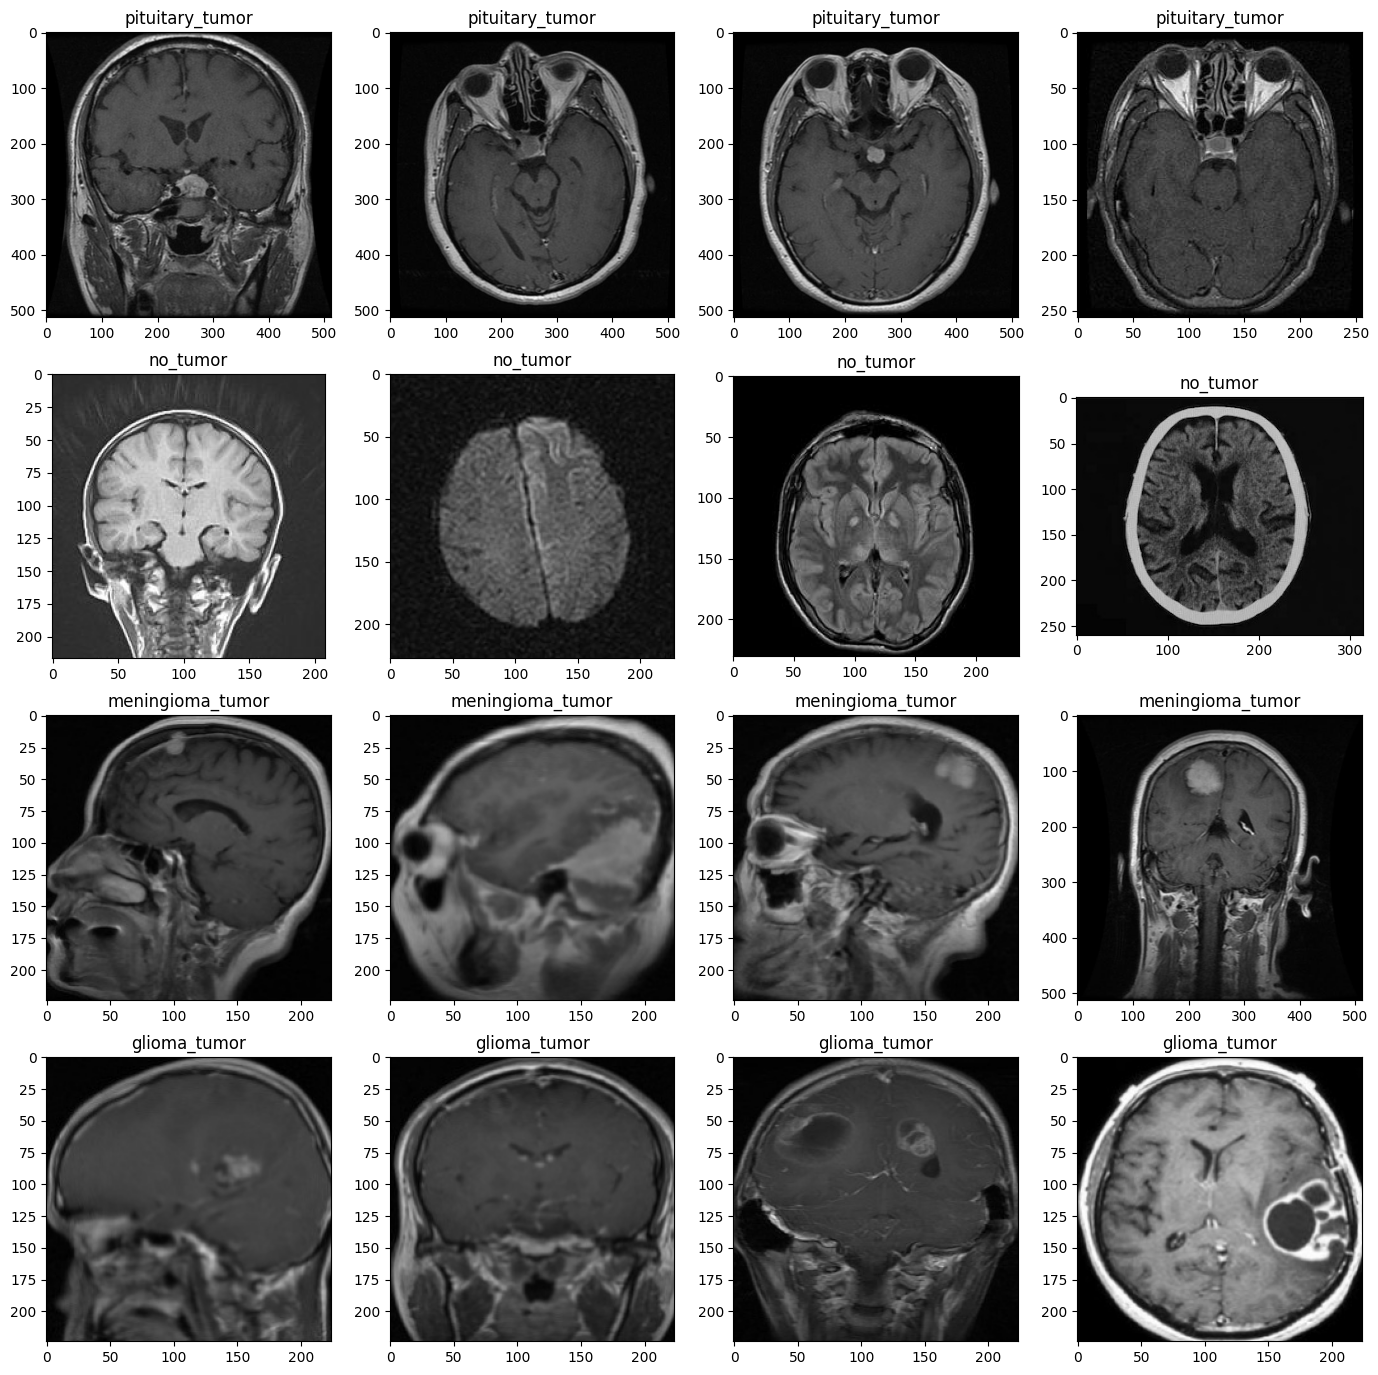

In [ ]:
# Visualisasi Data

# Tentukan path direktori untuk data latih dan uji
train_dir = "/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Training/"
test_dir = "/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Testing/"

# Daftarkan kelas-kelas yang ada dalam direktori latihan
classes = os.listdir("/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Training/")

# Buat fungsi untuk menyimpan path file untuk setiap kelas
files_path_dict = {}

# Isi fungsi dengan path file
for c in classes:
    files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))

# Buat gambar besar untuk subplot
plt.figure(figsize=(17, 17))

# Inisialisasi variabel indeks
index = 0

# Loop melalui setiap kelas
for c in classes:
    # Acak path file untuk setiap kelas
    random.shuffle(files_path_dict[c])

    # Ambil lima path file pertama untuk divisualisasikan
    path_list = files_path_dict[c][:5]

    # Loop melalui path file yang dipilih
    for i in range(1, 5):
        # Tambahkan nilai indeks
        index += 1

        # Buat subplot dalam gambar besar
        plt.subplot(4, 4, index)

        # Tampilkan gambar yang sesuai dengan path file
        plt.imshow(load_img(path_list[i]))

        # Tetapkan judul subplot dengan nama kelas yang bersesuaian
        plt.title(c)


Ket: menampilkan beberapa contoh gambar dari setiap kelas dalam dataset pelatihan. Gambar tersebut menampilkan empat baris dan empat kolom dari gambar. Setiap baris mewakili satu kelas, dan setiap kolom mewakili satu contoh gambar dari kelas tersebut.

### Crop and Save images

In [ ]:
# Fungsi untuk memotong gambar
def crop_image(image, plot=False):
    # Konversi gambar ke citra keabuan (grayscale)
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Terapkan Gaussian Blur untuk mengurangi noise
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # Terapkan thresholding untuk mendapatkan gambar biner
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    # Erosi untuk mengurangi noise
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    # Dilasi untuk mengisi area yang hilang setelah erosi
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    # Temukan kontur dalam gambar
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    # Pilih kontur terbesar (objek utama)
    c = max(contours, key=cv2.contourArea)

    # Temukan titik-titik ekstrem dari kontur (kiri, kanan, atas, bawah)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Potong gambar menggunakan titik-titik ekstrem
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    # Jika plot=True, tampilkan gambar asli dan yang dipotong
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Processed Image')
        plt.show()

    # Kembalikan gambar yang sudah dipotong
    return new_image


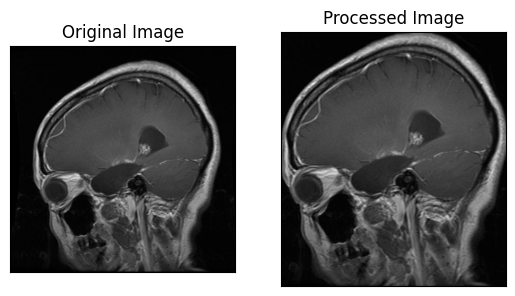

In [ ]:
# Check the crop

example_img = cv2.imread("/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Training/glioma_tumor/gg (101).jpg")
cropped_image_example = crop_image(example_img, plot=True)

In [ ]:
# Memotong Gambar Latih dan Menyimpan ke Direktori yang Sesuai
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

# Loop untuk glioma_tumor
j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Training/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

# Loop untuk meningioma_tumor
j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Training/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

# Loop untuk no_tumor
j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Training/no_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

# Loop untuk pituitary_tumor
j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Training/pituitary_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1


100%|██████████| 902/902 [00:27<00:00, 32.97it/s]


Ket: Persentase (100%) menunjukkan bahwa loop telah selesai.
Garis-garis hitam (██████████) memberikan indikasi tentang seberapa jauh proses telah berjalan.

100%|██████████| 901/901 [00:13<00:00, 65.79it/s]
Loop untuk kelas pituitary_tumor telah selesai.
Terdapat total 901 iterasi atau gambar.
Waktu yang diperlukan untuk loop adalah 13 detik.
Rata-rata kecepatan iterasi adalah sekitar 65.79 gambar per detik.

In [ ]:
# Memotong Gambar Pengujian dan Menyimpan ke Direktori yang Sesuai
glioma = test_dir + "glioma_tumor"
meningioma = test_dir + "meningioma_tumor"
no_tumor = test_dir + "no_tumor"
pituitary = test_dir + "pituitary_tumor"

# Loop untuk glioma_tumor
j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Testing/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

# Loop untuk meningioma_tumor
j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Testing/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

# Loop untuk no_tumor
j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Testing/no_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

# Loop untuk pituitary_tumor
j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Testing/pituitary_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


### Melakukan Augmentasi Data dan Siapkan Set Data Pelatihan, Validasi, dan Pengujian

In [ ]:
# untuk mempersiapkan data pelatihan, validasi, dan pengujian dalam konteks tugas klasifikasi gambar menggunakan deep learning.

# Menggunakan Image Data Generator
datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)

# Pembentukan Data Latih dengan Subset Validation
train_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Training/',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Pembentukan Data Validasi dengan Subset Validation
valid_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Training/',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Menggunakan Image Data Generator untuk Data Pengujian
test_datagen = ImageDataGenerator()

# Pembentukan Data Pengujian
test_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Testing/',
    target_size=(224,224),
    class_mode='categorical'
)


Found 7087 images belonging to 4 classes.
Found 1769 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [ ]:
# View the class dictionary

print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


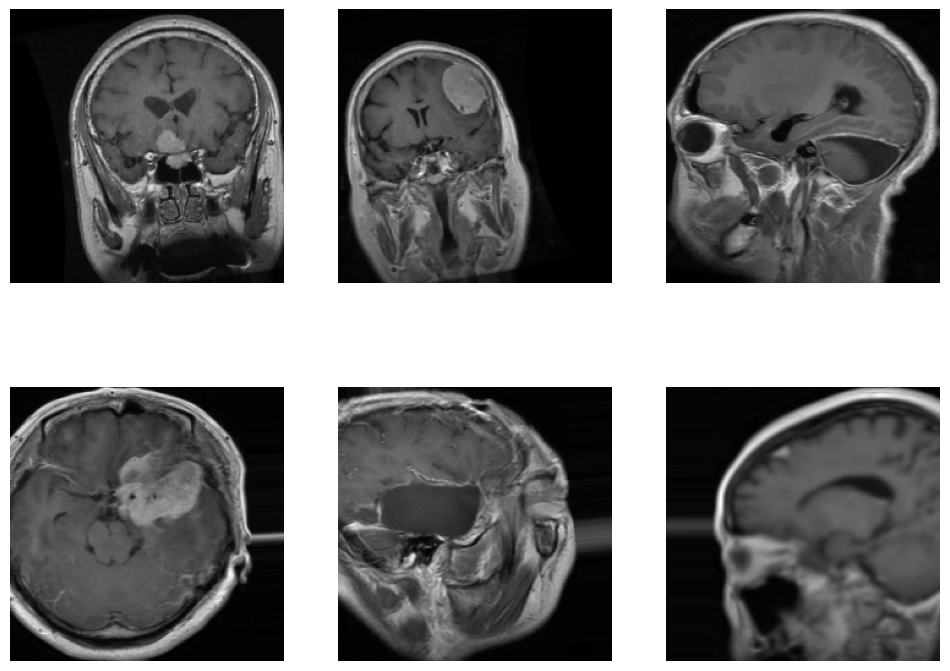

In [ ]:
# menampilkan sampel data yang telah di-augmentasi.
sample_x, sample_y =next(train_data)
plt.figure(figsize=(12,9))
# Menampilkan Sampel Gambar dalam Bentuk Plot
for i in range (6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()


### Build and Compile the model

In [ ]:
# Build the Model
# Membuat model EfficientNetB1 menggunakan kelas model EfficientNet

effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224,224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= effnet.input, outputs=model)
# Menampilkan ringkasan arsitektur model, termasuk jumlah parameter yang dapat di-train dan jumlah lapisan.

model.summary()

27018416/27018416 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [ ]:
# mengkompilasi model sebelum memulai proses pelatihan

model.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto", verbose=1)

### Train and Evaluate the model

In [ ]:
#melatih model mesin pembelajaran.


history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])


Epoch 1/7
222/222 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8914
Epoch 1: val_accuracy improved from -inf to 0.88468, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


222/222 [==============================] - 241s 783ms/step - loss: 0.3067 - accuracy: 0.8914 - val_loss: 0.3979 - val_accuracy: 0.8847
Epoch 2/7
222/222 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9581
Epoch 2: val_accuracy improved from 0.88468 to 0.92029, saving model to model.h5
222/222 [==============================] - 172s 776ms/step - loss: 0.1289 - accuracy: 0.9581 - val_loss: 0.3962 - val_accuracy: 0.9203
Epoch 3/7
222/222 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9667
Epoch 3: val_accuracy improved from 0.92029 to 0.93838, saving model to model.h5
222/222 [==============================] - 168s 757ms/step - loss: 0.0981 - accuracy: 0.9667 - val_loss: 0.1628 - val_accuracy: 0.9384
Epoch 4/7
222/222 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9811
Epoch 4: val_accuracy improved from 0.93838 to 0.95308, saving model to model.h5
222/222 [==============================] - 170s 766ms/step - loss: 

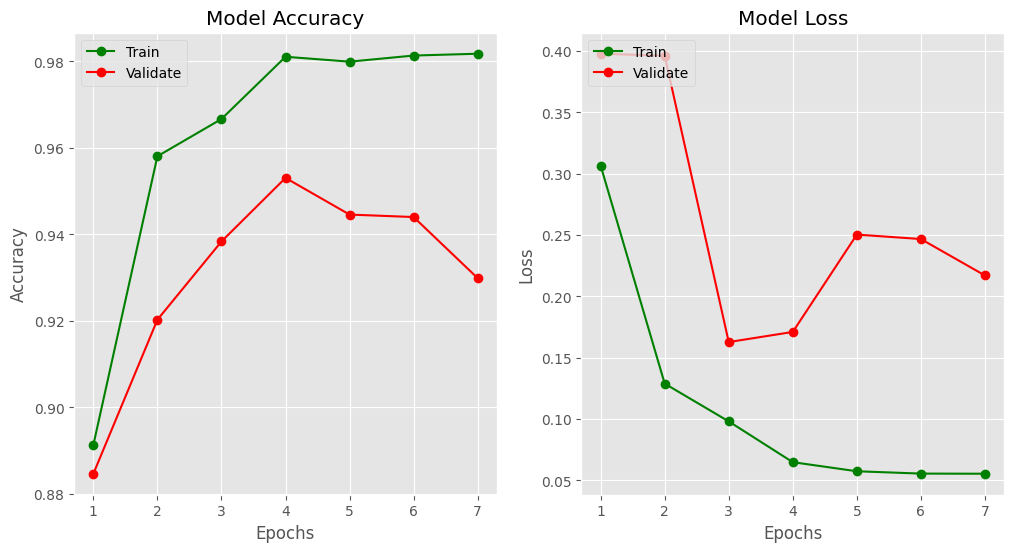

In [ ]:
# Plot the training curves

#Mengatur gaya plot
plt.style.use("ggplot")
#mengatur ukuran gambar menjadi (12,6) untuk memberikan lebar 12 inch dan tinggi 6 inch.
plt.figure(figsize=(12,6))
#Membuat rentang nilai epochs dari 1 hingga 7. Ini akan digunakan sebagai sumbu x pada grafik.
epochs = range(1,8)
#Membuat subplot pertama dalam grid 1x2 untuk grafik akurasi model. (1,2,1) berarti satu baris,
#dua kolom, dan subplot ini berada di posisi pertama.
plt.subplot(1,2,1)
#Plot kurva akurasi pelatihan
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Validate"], loc="upper left")

plt.subplot(1,2,2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Validate"], loc="upper left")

plt.show()

In [ ]:
# Evaluate the model on Test Set

model.evaluate(test_data)

1/1 [==============================] - 1s 511ms/step - loss: 0.1674 - accuracy: 0.9375


[0.16738921403884888, 0.9375]

### Obtain Predictions

1/1 [==============================] - 3s 3s/step
glioma_tumor


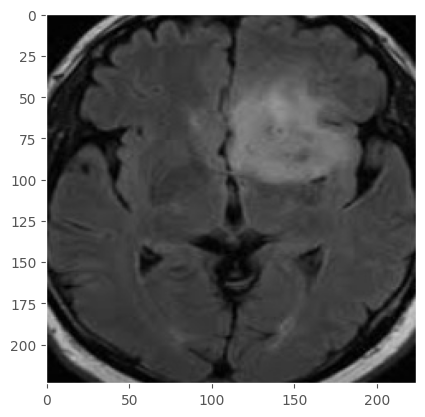

In [ ]:
# Obtain Prediction on Test Image

# Membuat dictionary untuk menghubungkan indeks kelas dengan nama kelas
class_dict = {0: "glioma_tumor", 1: "meningioma_tumor", 2: "no_tumor", 3: "pituitary_tumor"}

# Membaca gambar uji (test image) dari direktori file
test_img1 = cv2.imread("/content/drive/MyDrive/Brain_Tumor_Kel8/Brain_MRI/Testing/glioma_tumor/0.jpg")

# Menampilkan gambar uji menggunakan Matplotlib
plt.imshow(test_img1)
plt.grid(False)

# Menambahkan dimensi baru pada gambar untuk sesuai dengan model yang memerlukan batch size
test_img1 = np.expand_dims(test_img1, axis=0)

# Melakukan prediksi menggunakan model
pred = model.predict(test_img1)
# Mengambil indeks kelas dengan nilai probabilitas tertinggi
pred = np.argmax(pred)
# Mendapatkan nama kelas dari dictionary berdasarkan indeks prediksi
pred_class =class_dict[pred]
# Menampilkan hasil prediksi
print(pred_class)